
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_amarillo@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio A/B Testing Parametrico


In [402]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

#### Ejercicio 1:  Linea de montaje 

En una fabrica de componenetes textil se quiere comparar el tiempo de fabricacion de un determinado producto mediante tres métodos diferentes.  Se seleccionan aleatoriamente productos elaborados con cada uno de los métodos y se observa el tiempo de fabricación. 


1. ¿Se verifican los supuestos del modelo de análisis de la varianza?

2. ¿Existe evidencia de que el método influye en el tiempo medio de elaboración del producto?

3. La empresa valora que el tiempo de fabricación sea el menor posible. ¿Qué método cree que ofrece mejores resultados?

In [403]:
df_montaje = pd.read_csv("datos/linea_montaje.csv")

In [404]:
df_montaje.sample(2)

,minutos,metodo
42,1.263819,A
69,5.970559,B


Observamos que en los minutos tenemos valores negativos, representan tiempos de parada (pérdida), relevantes para nuestro estudio. Los vamos a eliminar ya que representaría en la media un beneficio en los tiempos. Luego en la media del método B penalizaremos sumando los valores negativos pero haciendo la media sobre los 48 en vez de los 50.

In [405]:
df_neg = df_montaje[df_montaje.minutos < 0]
df_neg

,minutos,metodo
76,-0.818899,B
99,-0.187206,B


In [406]:
df_montaje=df_montaje.drop(index=df_montaje[df_montaje.minutos < 0].index)

1. Análisis de varianza

Lo primero de todo, antes de comprobar las varianzas, será comprobar si estamos tratando con distribuciones normales. Para ello usaremos un test de Kolmogorov-Smirnov, donde compararemos nuestras muestras a una distribución normal que tendríamos si la muestra fuera normal. Las hipótesis planteadas serán:

$$H_0 : F(x) = G(x)$$
$$H_1 : F(x) \neq G(x)$$

In [407]:
metodos = df_montaje["metodo"].unique()
for i in metodos:
    globals()[f"met{i}"] = df_montaje[df_montaje["metodo"] == i]

In [408]:
def test_norm(df, col, sig_level):
    media = np.mean(df[col])
    sd = np.std(df[col])
    normal = np.random.normal(loc = media, scale = sd, size = df[col].shape[0])   
    pval = stats.kstest(df[col], normal).pvalue
    if pval < sig_level:
        print("Se rechaza la hipotesis nula, no es normal.")
    elif pval > sig_level:
        print("No se rechaza la hipótesis nula, es normal.")
    return stats.kstest(df[col], normal)

In [409]:
print("Método A:")
ksA = test_norm(metA, "minutos", 0.05)
print()
print("Método B:")
ksB = test_norm(metB, "minutos", 0.05)
print()
print("Método C:")
ksC = test_norm(metC, "minutos", 0.05)

Método A:
No se rechaza la hipótesis nula, es normal.

Método B:
No se rechaza la hipótesis nula, es normal.

Método C:
No se rechaza la hipótesis nula, es normal.


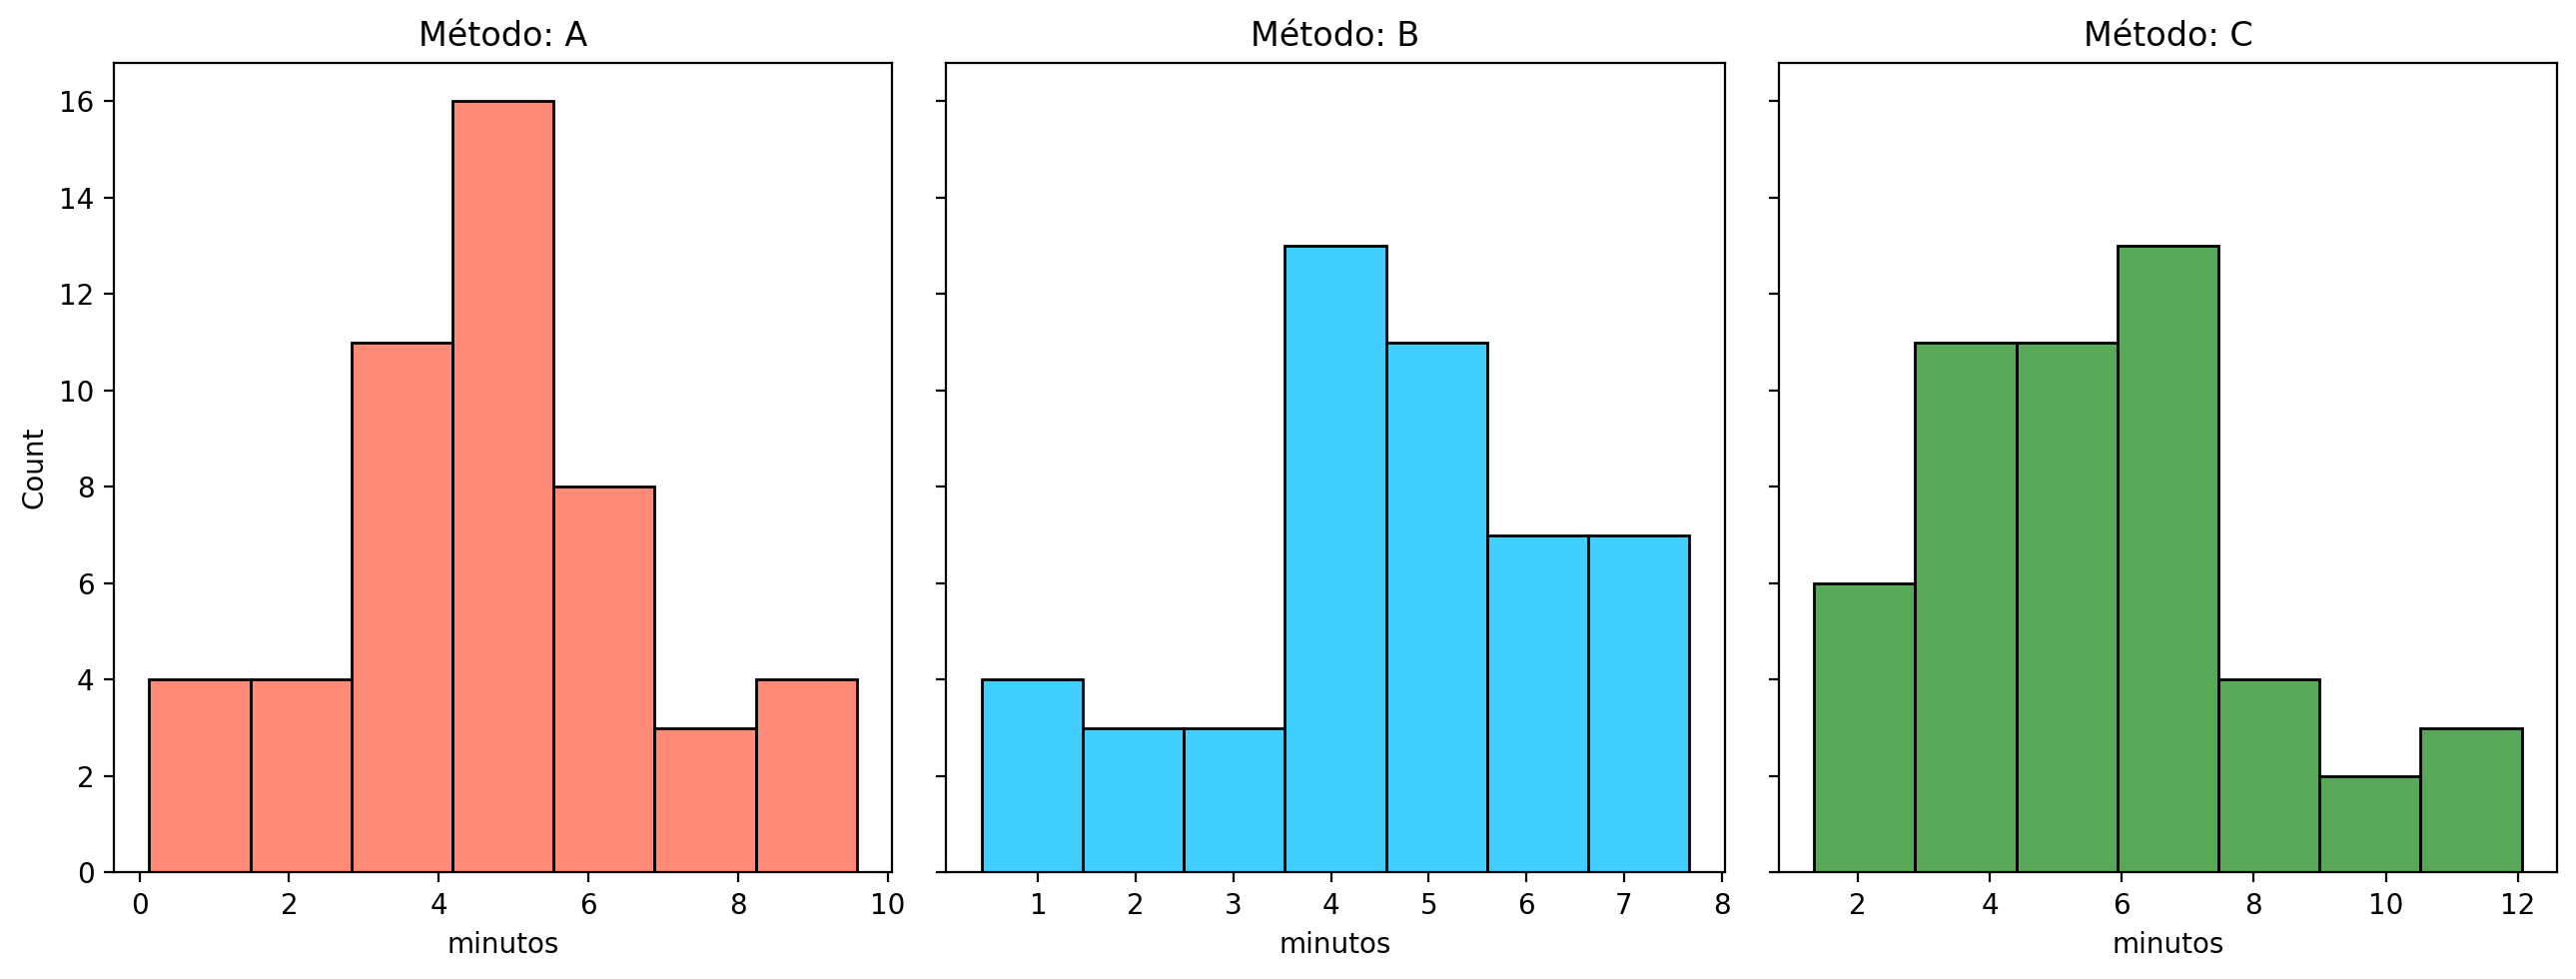

In [410]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize = (13,5), dpi = 200, sharey=True)
colors = ["tomato", "deepskyblue", "forestgreen"]
for i, met in enumerate(df_montaje["metodo"].unique()):
    axes[i].set_title(f"Método: {met}")
    sns.histplot(df_montaje[df_montaje["metodo"] == met]["minutos"], ax=axes[i], color = colors[i])
plt.tight_layout()


plt.show()

Las tres son distribuciones normales. Además, al tratarse de métodos diferentes y una selección aleatoria de los datos, representan una muestra independiente. Para la igualdad de varianzas, al tratarse de muestras que no se ajustan tanto a una dist. normal ideal, usaremos un test de levene, donde las hipótesis a plantear serán:

$$H_0 : \sigma_1^2 = \sigma_2^2$$
$$H_1 : \sigma_1^2 \neq \sigma_2^2$$


In [411]:
def var_levene(df, u_col, v_col, sig_level):
    uniques = df[u_col].unique()
    lista = []
    for u in uniques:
        lista.append(df[df[u_col] == u][v_col].values)
    lv = stats.levene(*lista)
    if lv.pvalue < sig_level:
        print("La hipótesis nula se rechaza, heterocedástica")
    elif lv.pvalue > sig_level:
        print("La hipótesis nula se acepta, homocedástica.")
    return lv

In [412]:
var_levene(df_montaje, "metodo", "minutos", sig_level=0.05)

La hipótesis nula se acepta, homocedástica.


LeveneResult(statistic=1.0626920726615094, pvalue=0.34819974732699716)

2. Influencia en el tiempo del método.


Al tratarse de 3 muestras, realizaremos un test ANOVA para comparar los tiempos de cada método.

In [413]:
def test_anova(df, u_col, v_col, sig_level):
    uniques = df[u_col].unique()
    lista = []
    for u in uniques:
        lista.append(df[df[u_col] == u][v_col].values)
    anova = stats.f_oneway(*lista)
    if anova.pvalue < sig_level:
        print("La hipótesis nula se rechaza, diferente media.")
    elif anova.pvalue > sig_level:
        print("La hipótesis nula se acepta, misma media.")
    return anova

In [414]:
test_anova(df_montaje, "metodo", "minutos", sig_level=0.05)

La hipótesis nula se rechaza, diferente media.


F_onewayResult(statistic=3.451228961333596, pvalue=0.034334606507256296)

El resultado demuestra una diferencia en la media de tiempos de fabricación entre métodos.

3. La empresa valora que el tiempo de fabricación sea el menor posible. ¿Qué método cree que ofrece mejores resultados?

Vamos a primero observar las medias de cada uno de los métodos. Para ello implementamos la penalización mencionada previamente para el método B.

In [415]:
media_penalizadaB = metB["minutos"].mean() + abs(df_neg["minutos"]).sum()/48

C:\Users\yanru\AppData\Local\Temp\ipykernel_10132\2757383949.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  tiempos_medios_df[1] = media_penalizadaB


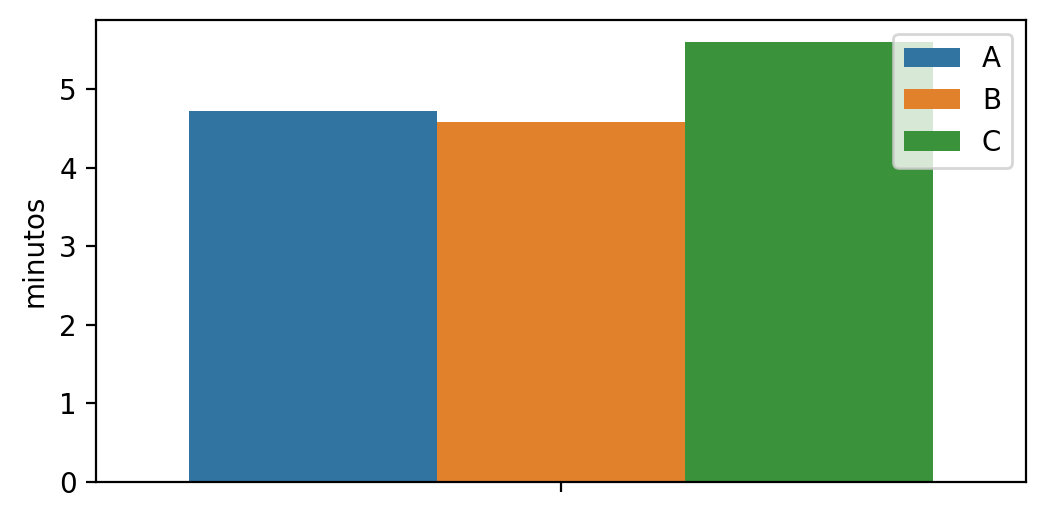

In [416]:
tiempos_medios_df = df_montaje.groupby("metodo")["minutos"].mean()
tiempos_medios_df[1] = media_penalizadaB
tiempos_medios_df = tiempos_medios_df.reset_index()
plt.figure(figsize=(6,3), dpi=200)
sns.barplot(tiempos_medios_df, y = "minutos", hue = "metodo")
plt.legend()
plt.show()

Viendo la gráfica podríamos decir que el método B es el más óptimo. Sin embargo podemos realizar un test de igualdad de medias entre A y B, para ver si estos dos presentan diferencias significativas (al 5%).

In [417]:
stats.f(metA["minutos"], metB["minutos"])

Esto nos demuestra que los métodos A y B presentan medias de tiempo no significativamente diferentes, por lo cual, aunque la media de B sea menor, sería razonable escoger el método A, el cual no presenta problemas de parada. De todas formas, el hecho de que la media de B sea menor, dado el test esto podría venir dado de procesos de azar.

#### Ejercicio 2: Densidad de Fluidos 


La convección es un mecanismo fundamental de transferencia de calor en fluidos, que ocurre debido a las variaciones en la densidad provocadas por diferencias de temperatura. Este fenómeno se manifiesta cuando las porciones del fluido que se calientan, al volverse menos densas, ascienden hacia regiones de menor temperatura, mientras que las porciones más frías, al ser más densas, descienden hacia las zonas donde la temperatura es más alta. Este movimiento continuo da lugar a las llamadas corrientes de convección, las cuales desempeñan un papel crucial en la distribución homogénea de la temperatura dentro del fluido, promoviendo un equilibrio térmico.

En este contexto, se ha diseñado y ejecutado un experimento con el propósito de investigar cómo se ve afectada la densidad de un fluido cuando se incrementa la temperatura en una región específica del sistema; por tanto se asegura la independencia y aleatoriedad del mismo. El objetivo del experimento es comprender en detalle las modificaciones en la densidad que resultan de este aumento térmico y cómo estas afectan el comportamiento global del fluido.


1. Analiza las suposiciones del modelo: ¿Se cumplen las condiciones de homocedasticidad, independencia y normalidad?
2. ¿Tiene la temperatura un impacto notable en la densidad del fluido?
3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

In [418]:
df_fluidos = pd.read_csv("datos/densidad_fluidos.csv")

In [419]:
temps = df_fluidos["temperatura"].unique()
for i in temps:
    globals()[f"dens{i}"] = df_fluidos[df_fluidos["temperatura"] == i]

1. Homocedasticidad, independencia y normalidad.

Ya que las variables fueron obtenidas a partir de diferentes regiones del sistema, nos asegura una independencia de los datos.

Ahora comprobemos la normalidad de los datos con un test de Kolmogorov-Smirnov:


In [420]:
print("Temperatura 100")
ks100 = test_norm(dens100, col = "densidad", sig_level=0.05)
print()
print("Temperatura 125")
ks125 = test_norm(dens125, col = "densidad", sig_level=0.05)
print()
print("Temperatura 150")
ks150 = test_norm(dens150, col = "densidad", sig_level=0.05)
print()
print("Temperatura 175")
ks175 = test_norm(dens175, col = "densidad", sig_level=0.05)

Temperatura 100
No se rechaza la hipótesis nula, es normal.

Temperatura 125
No se rechaza la hipótesis nula, es normal.

Temperatura 150
No se rechaza la hipótesis nula, es normal.

Temperatura 175
No se rechaza la hipótesis nula, es normal.


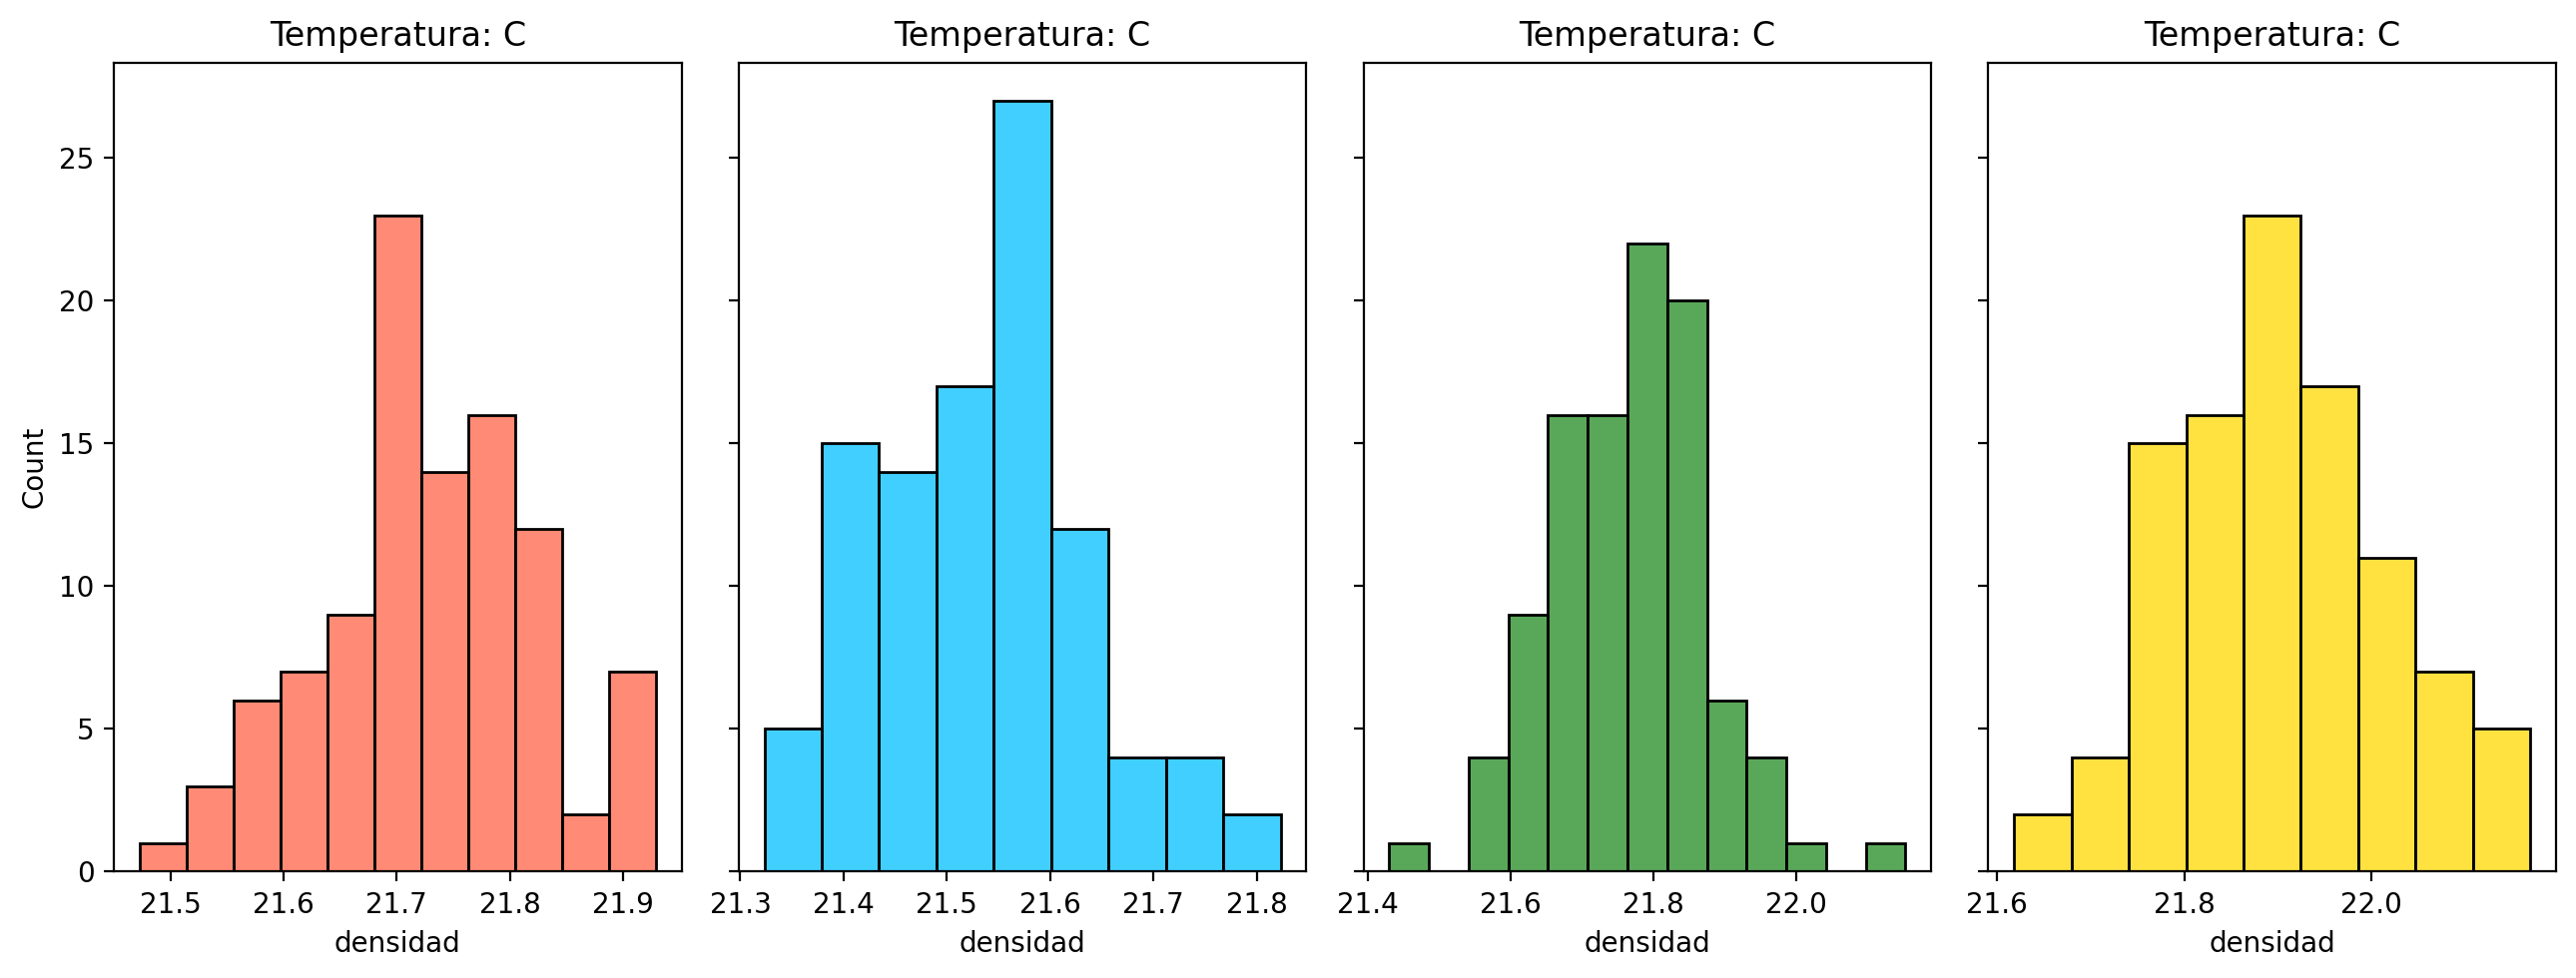

In [421]:
fig, axes = plt.subplots(nrows=1,ncols=4,figsize = (13,5), dpi = 200, sharey=True)
colors = ["tomato", "deepskyblue", "forestgreen", "gold"]
for i, temp in enumerate(df_fluidos["temperatura"].unique()):
    axes[i].set_title(f"Temperatura: {met}")
    sns.histplot(df_fluidos[df_fluidos["temperatura"] == temp]["densidad"], ax=axes[i], color = colors[i])
plt.tight_layout()

plt.show()

Ya que las distribuciones no son perfectamente normales, para comprobar la homocedasticidad usaremos el test de levene.

In [422]:
var_levene(df_fluidos, u_col="temperatura", v_col="densidad", sig_level=0.05)

La hipótesis nula se acepta, homocedástica.


LeveneResult(statistic=1.3647908525254946, pvalue=0.25311302633232835)

Obtenemos que las varianzas entre muestras es la misma dado el nivel de significancia, por lo que es homocedástica.

2. Impacto notable de la temperatura?

Para comprobar el impacto de las diferentes temperaturas, usaremos un test ANOVA ya que estamos tratando con más de 2 distribuciones.

In [423]:
test_anova(df_fluidos, u_col="temperatura", v_col="densidad", sig_level=0.05)

La hipótesis nula se rechaza, diferente media.


F_onewayResult(statistic=212.84277610615817, pvalue=3.327798065119595e-82)

Existe un impacto significativo en las densidades por causa de las temperaturas. El test no indica cuáles son las temperaturas que nos dan ese impacto. Podemos hacer un t-test por pares para ver cuáles son las que presentan diferencias entre sí.

In [424]:
df_fluidos.groupby("temperatura")["densidad"].mean()

temperatura
100    21.729410
125    21.532402
150    21.766618
175    21.903682
Name: densidad, dtype: float64

Vamos a coger la menos obvia, 100 con 150:

In [425]:
stats.ttest_ind(dens100["densidad"], dens150["densidad"])

TtestResult(statistic=-2.579658792093261, pvalue=0.010614196963283503, df=198.0)

Lo cual indica que esa diferencia de medias es significativa.

3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

Podemos agrupar los datos por grupos de (100,125) y (150,175) y realizar un t-test:

In [426]:
dens100125 = pd.concat([dens100, dens125])
dens150175 = pd.concat([dens150, dens175])

In [431]:
stats.ttest_ind(dens100125["densidad"], dens150175["densidad"])

TtestResult(statistic=-15.129677894969593, pvalue=3.563849634924047e-41, df=398.0)

El pvalue es bastante menor a 0.05, por lo que podemos rechazar la hipótesis nula de igualdad de medias, por lo que hay una diferencia significativa entre medias. Si miramos la gráfica no resulta intuitivo, por lo que es buena idea siempre realizar un contraste de hipótesis.

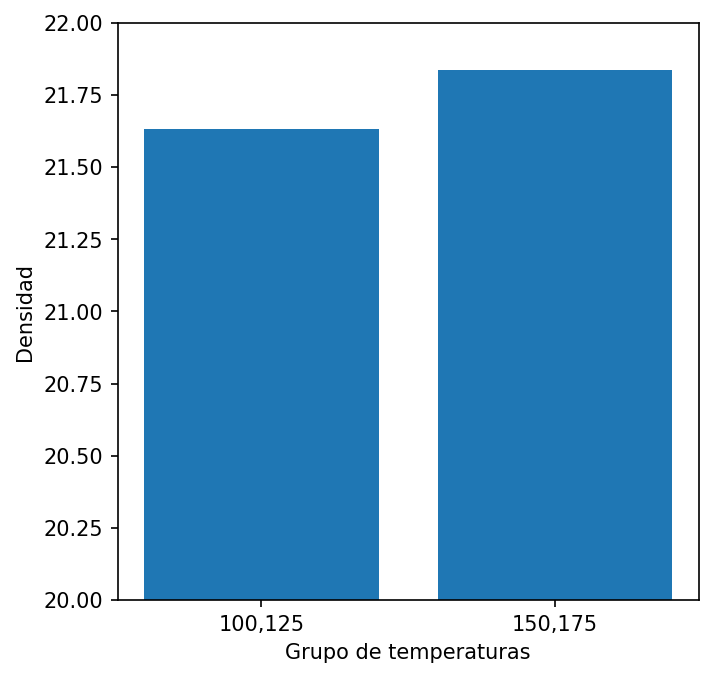

In [444]:
plt.figure(figsize=(5,5), dpi = 150)
plt.bar(x = ["100,125", "150,175"], 
        height = [dens100125["densidad"].mean(), dens150175["densidad"].mean()])
plt.ylim(20,22)
plt.xlabel("Grupo de temperaturas")
plt.ylabel("Densidad")
plt.show()

Concluyendo, las temperaturas de 150 y 175 son significativamente mayores a las de 100 y 125.